# Import libraries and modules

In [8]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from pathlib import Path

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

from ck_utils import (
    readCKExpData,
    load_kappa_values,
    solve_ODE_system,
    solve_ODE_system_numbalsoda
)

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

# Load data

In [9]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

job_folder = 'ck_experiments_constrained'
kappa_dir = 'ck_20clusters_0605_162945_skip'

km, kp = load_kappa_values(Path(current_dir) / job_folder / kappa_dir)

SS = len(km)  # Number of clusters

# Load experimental data
t_values, N_clusters = readCKExpData(exp_dir, Nsize=SS)

# Initial conditions
c0 = N_clusters[0,:] 

# Kappas to np array
km = np.array(km)
kp = np.array(kp)

In [10]:
km.shape, kp.shape, type(c0[0]), type(km[0]), N_clusters.shape

((20,), (20,), numpy.float64, numpy.float64, (16257, 20))

# Solve ODEs and plot results

In [11]:
import numba as nb
from numbalsoda import solve_ivp, lsoda_sig

@nb.cfunc(lsoda_sig)
def f(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]
    
@nb.njit()
def f_scipy(t, u):
    return np.array([u[0]-u[0]*u[1],u[0]*u[1]-u[1]])

funcptr = f.address
u0 = np.array([5.,0.8])
data = np.array([1.0])
t_eval = np.linspace(0.0,50.0,1000)
t_span = np.array([min(t_eval),max(t_eval)])

## Solve ODEs

In [14]:
# Solve ODE system
# N_sol = solve_ODE_system(c0, t_values, km, kp)
N_sol = solve_ODE_system_numbalsoda(c0, t_values, km, kp)

## Plot results

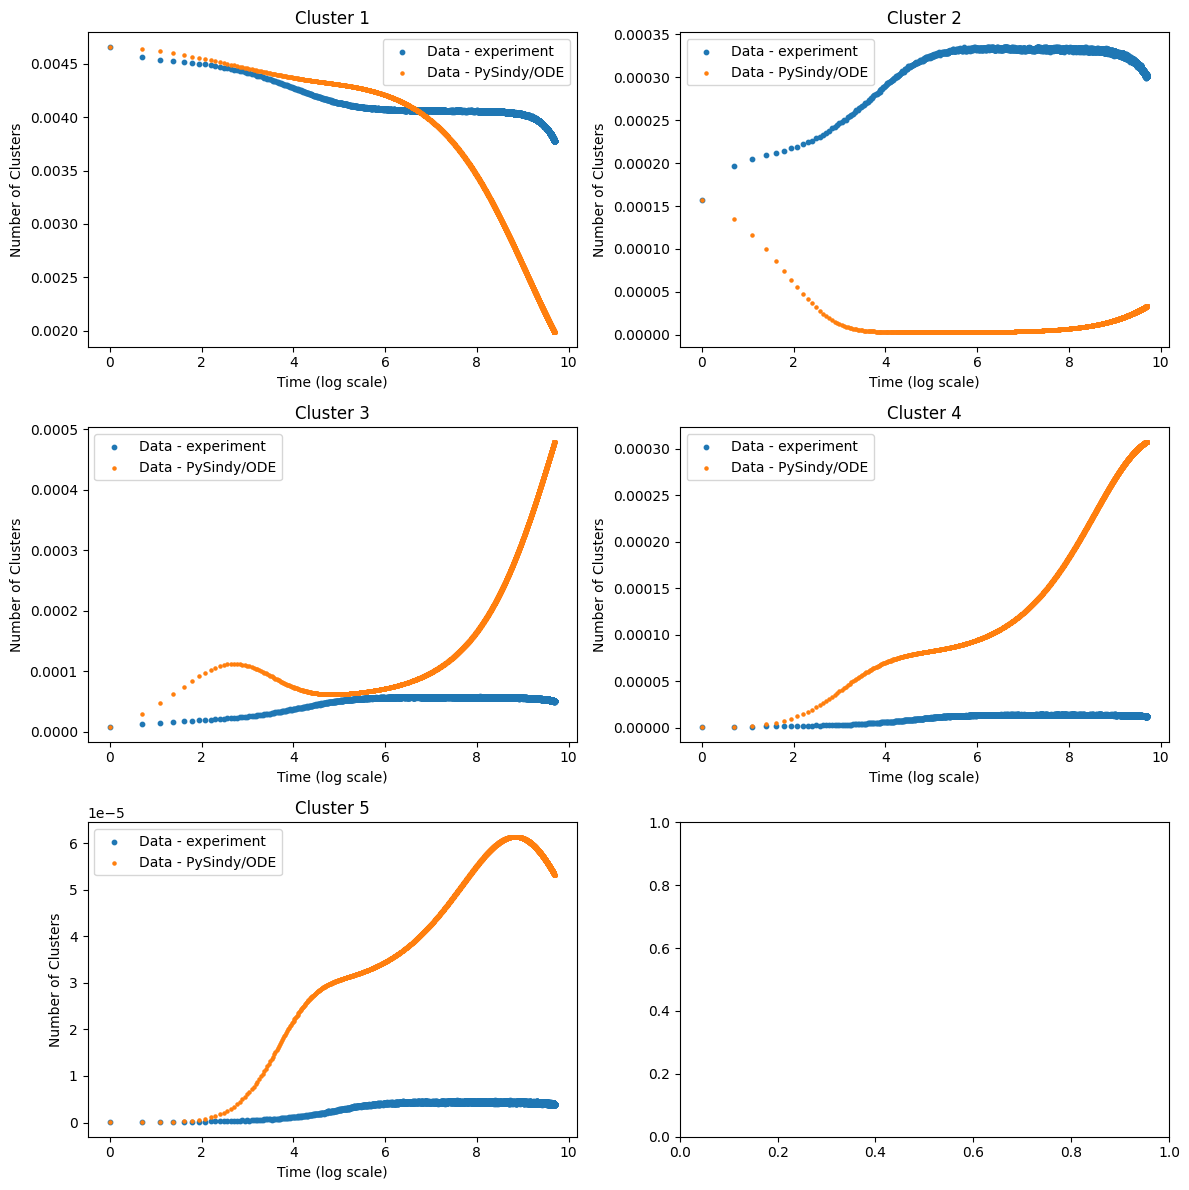

In [ ]:
# Ensure previous figures are closed
plt.close('all')

# Compute the logarithm of the time values using np.log1p
log_t_values = np.log1p(t_values)

# CLUSTERS_TO_PLOT = [1, 2, 5, 10, 20, 50, 100]
CLUSTERS_TO_PLOT = [1, 2, 3, 4, 5]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Plot solution
for ci, clust in enumerate(CLUSTERS_TO_PLOT):
    if clust > 0 and clust <= SS:

        if clust > SS:
            print(f"Cluster size {clust} is larger than the system size {SS}")
            continue
        
        # Plot the data with log scale on the x-axis
        axs[ci].scatter(log_t_values, N_clusters[:, clust-1], s=10, label='Data - experiment')
        axs[ci].scatter(log_t_values, N_sol[:, clust-1], s=5, label=f'Data - PySindy/ODE')

        axs[ci].set_title(f'Cluster {clust}')
        axs[ci].legend()
        axs[ci].set_xlabel('Time (log scale)')
        axs[ci].set_ylabel('Number of Clusters')

# # Save the figure
plt.tight_layout()
plt.show()

# Close the plot to free resources
plt.close()